In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [2]:
dataset = pd.read_csv('../modeldata/AllFeatMod.csv')

In [14]:
dataset = pd.read_csv('../modeldata/AllFeatLonger.csv')
dataset['3BRfirstfillfac']

0         0.084930
1         0.135156
2         0.193920
3         0.016416
4         0.861476
            ...   
138538    0.299911
138539    0.041516
138540    0.171139
138541    0.074269
138542    0.058127
Name: 3BRfirstfillfac, Length: 138543, dtype: float64

In [4]:
dataset = pd.read_csv('../modeldata/AllFeatLonger.csv')


In [15]:
dataset = dataset.drop('logInstT3BR', axis=1)
dataset = dataset.drop('3Bfirstfillfac', axis=1)

In [16]:
resRemove =  pd.read_csv('../../cleanData/csvs/resonant/removeLables.csv')
randRemove =  pd.read_csv('../../cleanData/csvs/random/removeLables.csv')

In [17]:
randRemove=randRemove.drop('Unnamed: 0',axis=1)

In [18]:
remove = pd.concat([resRemove,randRemove])

In [19]:
dataset = dataset.drop(remove[remove['remove']==True].index)

In [20]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [21]:
%%time
if 'hasnull' not in dataset.columns:
    dataset['hasnull'] = dataset.apply(hasnull, axis=1)
    #dataset['tmax'] = dataset.apply(tmax, axis=1)
    # dataset['tmax'] = dataset.apply(lambda x:1e4, axis=1) # this version would just set tmax=1e4 for all of them

    #dataset.to_csv(trainingdatafolder+"trainingdata.csv", encoding='ascii')

CPU times: user 5.61 s, sys: 77.4 ms, total: 5.68 s
Wall time: 5.68 s


In [22]:
dataset.iloc[1][15:]

MMRstrengthWfar                 0.008421
MMRstrengthWMAXfar              0.008921
twoMMRstrengthWfar              0.004415
twoMMRstrengthWMAXfar           0.004814
EMcrossouter                    0.671403
EMfracstdouter                  0.030209
EPstdouter                      0.010563
MMRstrengthouter                0.000309
twoMMRstrengthouter                  0.0
MMRstrengthWouter                0.00104
MMRstrengthWMAXouter            0.001921
twoMMRstrengthWouter                 0.0
twoMMRstrengthWMAXouter              0.0
MEGNO                          22.829327
MEGNOstd                        7.319093
threeBRfillfac                  0.387182
threeBRfillstd                   0.00199
chiSec                           0.06995
ThetaSTD                        53.21073
p2/1                            1.299174
p3/2                            1.663194
Zval12                          0.002016
Zcrit12                         6.079126
Zval23                          0.060456
Zcrit23         

In [23]:
dataset['log']= np.log10(dataset['ThetaSTD']/1.8)

In [24]:
dataset.describe()


,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,MMRstrengthWMAXnear,twoMMRstrengthWnear,twoMMRstrengthWMAXnear,...,Zcrit12,Zval23,Zcrit23,IntZval12,IntZval23,3BRfirstfillfac,instability_time,shadow_instability_time,hasnull,log
count,127440.000000,127440.000000,113389.000000,1.133890e+05,1.133890e+05,113389.000000,1.133890e+05,1.274400e+05,113389.000000,1.274400e+05,...,1.274400e+05,127440.000000,1.274400e+05,127440.000000,127440.000000,127440.000000,1.274400e+05,1.274400e+05,127440.000000,113389.000000
mean,69355.834393,0.150420,0.067495,3.776447e-03,5.820197e-01,0.027406,7.524591e-03,3.463836e+04,0.007200,3.463907e+04,...,1.666997e+39,0.037592,6.718208e+41,0.048692,0.045197,0.128643,2.877484e+08,2.940185e+08,0.110256,0.162792
std,40798.487969,0.113239,0.096313,7.704116e-03,1.895600e+00,0.377211,2.778559e-02,7.812912e+06,0.027139,7.813070e+06,...,5.707826e+41,0.041554,2.398305e+44,0.052830,0.044528,0.419832,4.379344e+08,4.425095e+08,0.313210,1.007508
min,0.000000,0.004612,0.000050,4.554355e-07,3.591267e-10,0.000000,1.209114e-09,3.189701e-09,0.000000,0.000000e+00,...,1.313949e+00,0.000006,1.061155e+00,0.000019,0.000007,0.000000,3.464102e-02,0.000000e+00,0.000000,-2.552019
25%,33844.750000,0.072461,0.018337,2.996613e-04,5.277124e-02,0.006157,1.636624e-03,2.756198e-03,0.001618,2.453962e-03,...,1.759221e+00,0.009943,1.744968e+00,0.015175,0.014947,0.024813,6.383801e+04,5.757042e+04,0.000000,-0.683366
50%,68642.500000,0.118173,0.037938,1.020053e-03,1.376027e-01,0.015288,3.981097e-03,6.271675e-03,0.003844,5.691691e-03,...,3.121152e+00,0.023411,3.073673e+00,0.031948,0.031023,0.059586,1.482248e+06,1.506353e+06,0.000000,-0.127781
75%,105455.250000,0.187903,0.076235,3.662539e-03,4.578894e-01,0.029042,9.413441e-03,1.333836e-02,0.008498,1.235993e-02,...,1.799500e+01,0.049905,1.794958e+01,0.062781,0.060302,0.131139,1.000000e+09,1.000000e+09,0.000000,1.092453
max,138542.000000,0.982453,6.898526,1.836789e-01,2.183786e+02,82.427281,3.603727e+00,2.461150e+09,3.589497,2.461200e+09,...,2.035996e+44,0.465614,8.561648e+46,0.703917,0.467625,35.946372,1.000050e+09,1.000050e+09,1.000000,2.624376


In [25]:
dataset.columns

Index(['index', 'EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'twoMMRstrengthnear', 'MMRstrengthWnear', 'MMRstrengthWMAXnear',
       'twoMMRstrengthWnear', 'twoMMRstrengthWMAXnear', 'EMcrossfar',
       'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'twoMMRstrengthfar',
       'MMRstrengthWfar', 'MMRstrengthWMAXfar', 'twoMMRstrengthWfar',
       'twoMMRstrengthWMAXfar', 'EMcrossouter', 'EMfracstdouter', 'EPstdouter',
       'MMRstrengthouter', 'twoMMRstrengthouter', 'MMRstrengthWouter',
       'MMRstrengthWMAXouter', 'twoMMRstrengthWouter',
       'twoMMRstrengthWMAXouter', 'MEGNO', 'MEGNOstd', 'threeBRfillfac',
       'threeBRfillstd', 'chiSec', 'ThetaSTD', 'p2/1', 'p3/2', 'Zval12',
       'Zcrit12', 'Zval23', 'Zcrit23', 'IntZval12', 'IntZval23',
       '3BRfirstfillfac', 'prelimStable', 'Stable', 'instability_time',
       'shadow_instability_time', 'hasnull', 'log'],
      dtype='object')

In [26]:
IntDat = ['threeBRfillfac','log','Zcrit12','Zcrit23','IntZval12','IntZval23','MEGNO','EMcrossnear','EMcrossfar','EMcrossouter','MMRstrengthnear','MMRstrengthfar']
Dat = ['threeBRfillfac','log','Zcrit12','Zcrit23','Zval12','Zval23','MEGNO','EMcrossnear','EMcrossfar','EMcrossouter','MMRstrengthnear','MMRstrengthfar']
all = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'twoMMRstrengthnear', 'MMRstrengthWnear', 'MMRstrengthWMAXnear',
       'twoMMRstrengthWnear', 'twoMMRstrengthWMAXnear', 'EMcrossfar',
       'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'twoMMRstrengthfar',
       'MMRstrengthWfar', 'MMRstrengthWMAXfar', 'twoMMRstrengthWfar',
       'twoMMRstrengthWMAXfar', 'EMcrossouter', 'EMfracstdouter', 'EPstdouter',
       'MMRstrengthouter', 'twoMMRstrengthouter', 'MMRstrengthWouter',
       'MMRstrengthWMAXouter', 'twoMMRstrengthWouter',
       'twoMMRstrengthWMAXouter', 'MEGNO', 'MEGNOstd', 'threeBRfillfac',
       'threeBRfillstd', 'chiSec', 'ThetaSTD', 'p2/1', 'p3/2', 'Zval12',
       'Zcrit12', 'Zval23', 'Zcrit23', 'IntZval12', 'IntZval23','log']

In [27]:
mask = (dataset['hasnull'] == 0 )
filtData = dataset[mask]

In [28]:
plot = filtData

In [29]:
scrambled = plot.sample(frac=1)

In [30]:
scrambled = scrambled.reset_index()

In [31]:
scrambled = scrambled.drop(scrambled[scrambled['Zcrit12']>1e5].index)
scrambled = scrambled.drop(scrambled[scrambled['Zcrit23']>1e5].index)


In [32]:
scrambled

,level_0,index,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,twoMMRstrengthnear,MMRstrengthWnear,MMRstrengthWMAXnear,twoMMRstrengthWnear,...,Zcrit23,IntZval12,IntZval23,3BRfirstfillfac,prelimStable,Stable,instability_time,shadow_instability_time,hasnull,log
0,103047,103047,0.129351,0.018595,0.000152,0.491636,0.007749,0.004251,0.004884,0.004133,...,10.543871,0.019071,0.013702,0.017307,True,True,1.000000e+09,1.000000e+09,0,-0.788386
1,64398,64398,0.205582,0.136534,0.008716,0.029758,0.001572,0.002464,0.003693,0.001091,...,2.046394,0.070567,0.043014,0.147693,True,False,5.783519e+08,1.532764e+06,0,-0.028417
2,110907,110907,0.182576,0.026720,0.000064,0.177564,0.008987,0.000862,0.001566,0.003616,...,4.312780,0.002806,0.011002,0.005774,True,True,1.000000e+09,1.000000e+09,0,0.404319
3,134674,134674,0.177566,0.022717,0.002253,0.017444,0.014495,0.000435,0.004661,0.004282,...,3.261048,0.013215,0.033831,0.051700,True,False,8.883863e+07,5.611569e+07,0,-0.498513
4,77855,77855,0.129402,0.047646,0.000250,0.113773,0.003838,0.001983,0.002926,0.001928,...,1.733963,0.013189,0.062199,0.079715,True,False,6.301899e+05,1.257753e+06,0,1.242577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113384,18576,18576,0.175402,0.001007,0.000009,0.005793,0.004717,0.001519,0.001530,0.000239,...,1.622442,0.018603,0.018385,0.006006,True,True,1.000000e+09,1.000000e+09,0,1.465573
113385,108172,108172,0.105295,0.133363,0.008575,0.032318,0.004983,0.001860,0.002227,0.001581,...,3.342344,0.019965,0.042978,0.062336,True,False,2.925361e+05,6.759983e+04,0,-0.569643
113386,66523,66523,0.128595,0.042396,0.001739,0.420598,0.029948,0.016218,0.018571,0.015911,...,1.398913,0.024894,0.024138,0.227451,True,True,1.000000e+09,1.000000e+09,0,-0.508835
113387,118409,118409,0.038854,0.006772,0.000868,0.967875,0.012119,0.001819,0.001839,0.001821,...,1.618268,0.017070,0.015032,0.057318,True,True,1.000000e+09,1.000000e+09,0,-1.770072


Now we do the train test split manually. We take 80\% of the rows for training, 20\% for testing (this is what we were doing before too)

In [33]:
#deciding training and not training, order is random
Nrows = int(0.8*scrambled.shape[0])
train = scrambled.iloc[:Nrows, :]
test = scrambled.iloc[Nrows:, :]
#test_tinst = tinst.iloc[Nrows:]


# dtrain = xgb.DMatrix(trainX, trainY)
# dtest = xgb.DMatrix(testX, testY)

In [34]:
#features var covers all features
resultBalance = train['Stable'].value_counts()[False]/train['Stable'].value_counts()[True]

In [35]:
realTest = test.loc[test['prelimStable']==True]

In [36]:
testT = realTest.loc[test['Stable'] == True]
testF = realTest.loc[test['Stable'] == False]


In [37]:
tT = pd.concat([testT, testF.sample(n=7300)])
tT = tT.sample(frac=1)

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix, auc
import sklearn

In [39]:
testModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 30, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [40]:
testModel.fit(train[all], train["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = sklearn.metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

Text(0.5, 1.0, 'ROC curve (AUC = 0.974)')

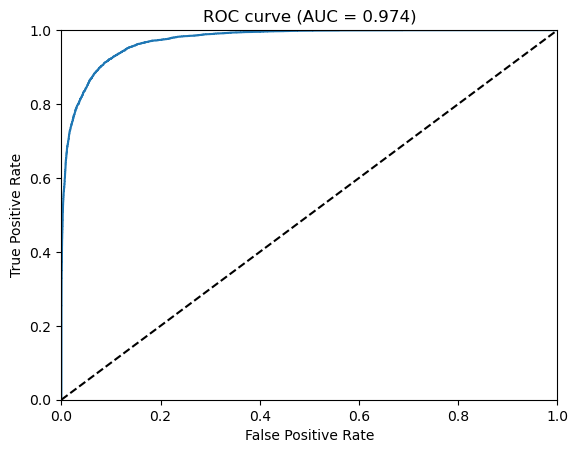

In [42]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testModel, test[all], test['Stable'])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [43]:
resPred = testModel.predict_proba(tT[all])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(testModel.predict(tT[all]), tT["Stable"]))

0.9744673405595762
0.9050695825049702


0.9431740032502489
0.8571023130410104

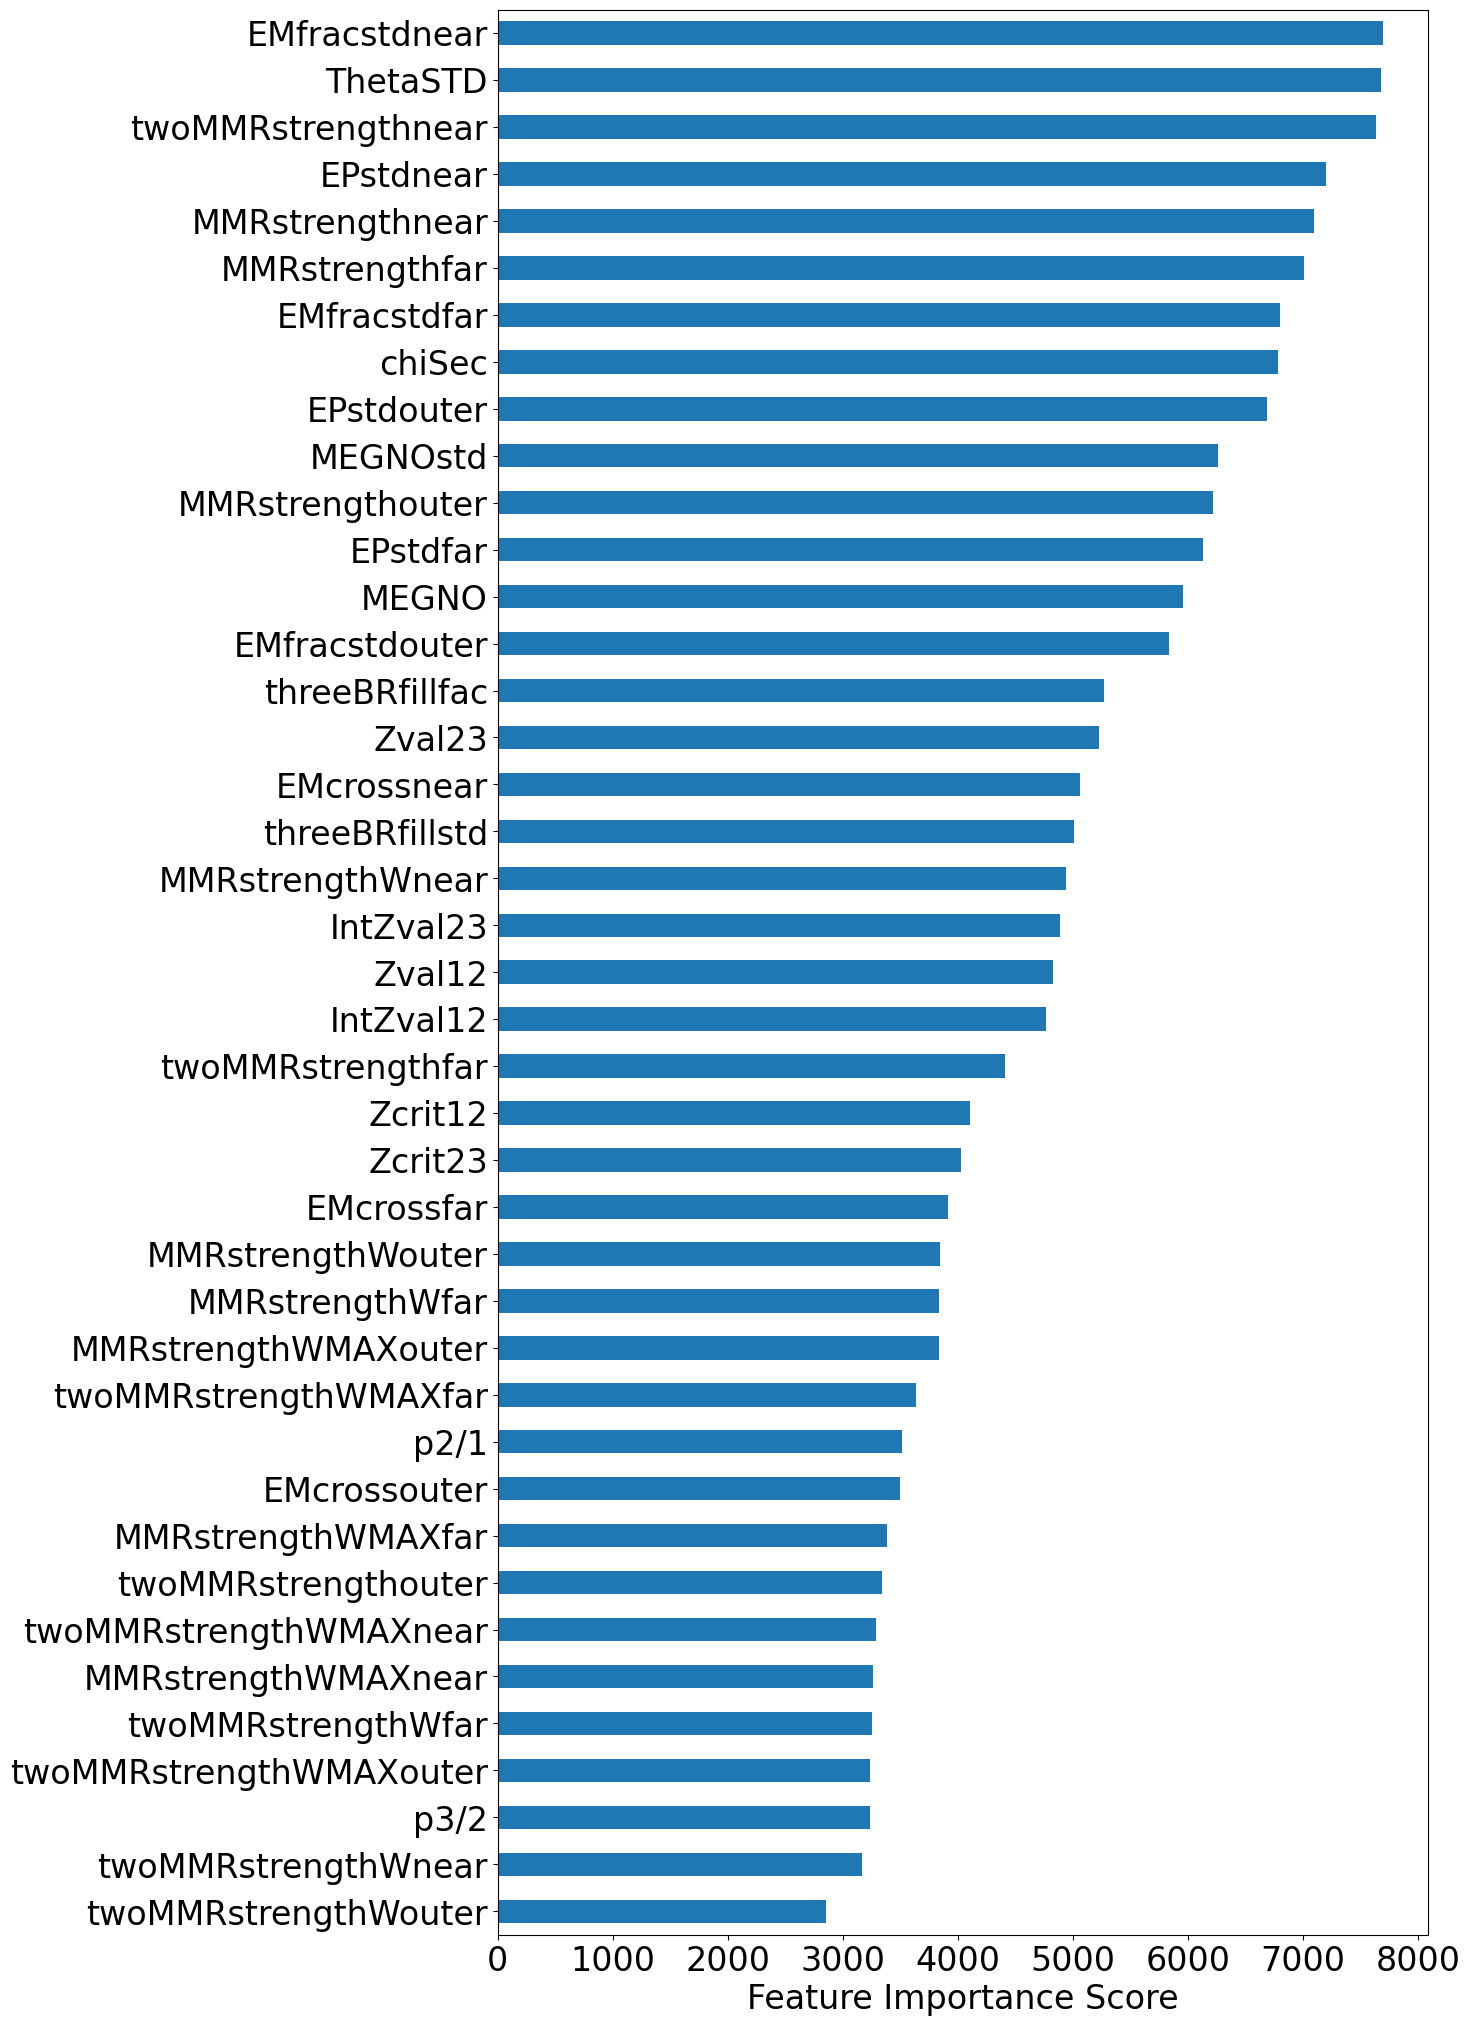

In [44]:
feat_imp = pd.Series(testModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,25), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

# compair intigrated paired down verses not intigrated

In [45]:
noInt = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 30, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

Int = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 30, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

In [46]:
noInt.fit(train[Dat], train["Stable"])
Int.fit(train[IntDat], train["Stable"])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Text(0.5, 1.0, 'Int ROC curve (AUC = 0.960)')

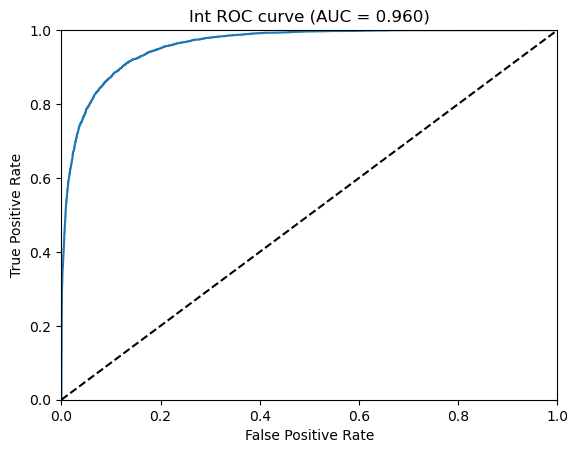

In [47]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(Int, test[IntDat], test['Stable'])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Int ROC curve (AUC = {0:.3f})'.format(roc_auc))

Text(0.5, 1.0, 'NoInt ROC curve (AUC = 0.958)')

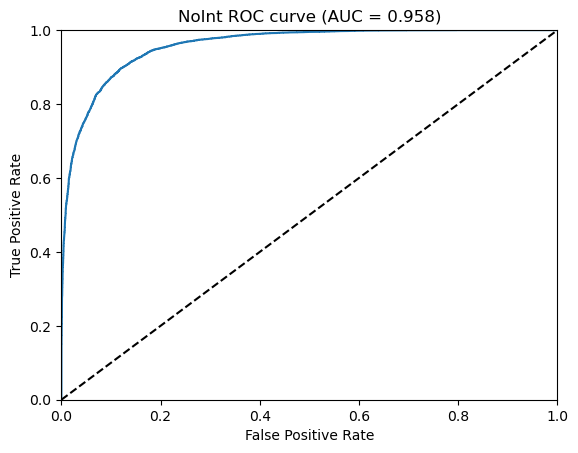

In [48]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(noInt, test[Dat], test['Stable'])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('NoInt ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [11]:
partModel = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 30, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance)

NameError: name 'resultBalance' is not defined

In [ ]:
part = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 
       ]

In [ ]:
#part = ['threeBRfillfac','log','Zcrit12','Zcrit23','Zval12','Zval23','MEGNO','EMcrossnear','EMcrossfar','twoMMRstrengthnear']

partModel.fit(train[part],train['Stable'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=30, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Text(0.5, 1.0, ' ROC curve (AUC = 0.961)')

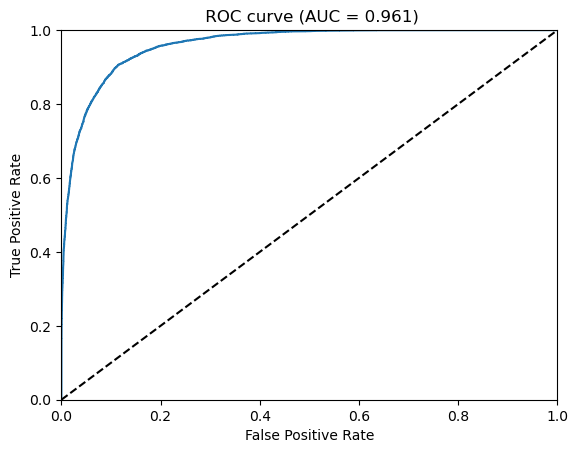

In [ ]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(partModel, test[part], test['Stable'])

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(' ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [ ]:
resPred = partModel.predict_proba(tT[part])[:,1]

print (metrics.roc_auc_score(tT['Stable'],resPred))
print(accuracy_score(partModel.predict(tT[part]), tT["Stable"]))

0.9590172939584585
0.885159262962434


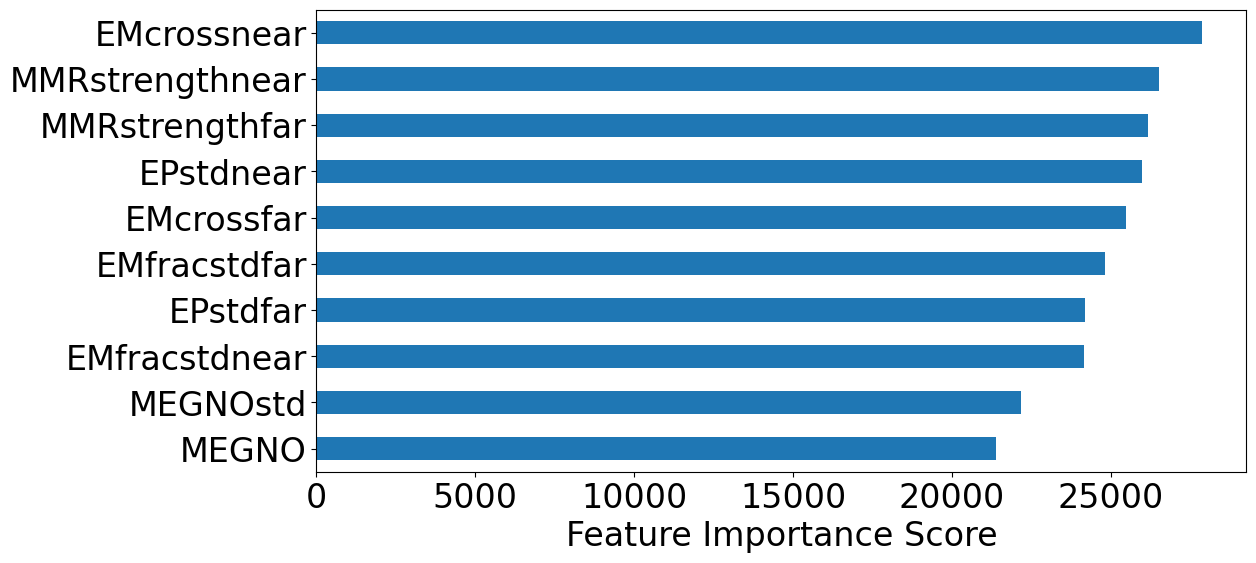

In [ ]:
feat_imp = pd.Series(partModel.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

In [50]:
tm = XGBRegressor(learning_rate = 0.06, 
                         max_depth = 30, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         )

In [51]:
tm.fit(train[all],np.log10(train['instability_time']))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=30, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [53]:
mse = mean_squared_error(np.log10(test['instability_time']), tm.predict(test[all]))
print('Mean Squared Error:', mse)

Mean Squared Error: 0.619109190123256


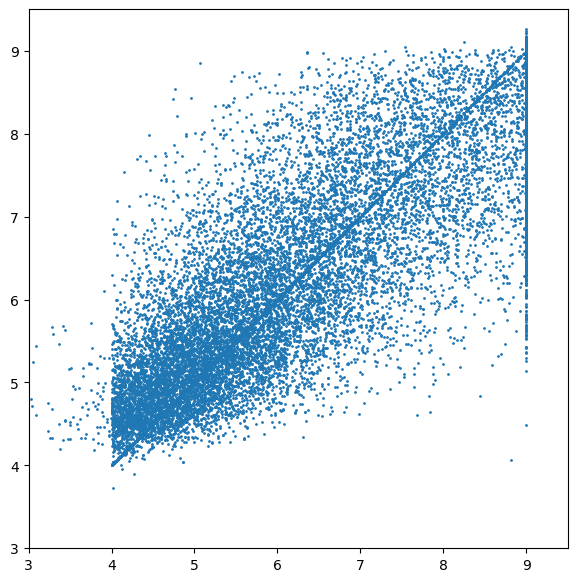

<Figure size 1000x1000 with 0 Axes>

In [57]:
figure = plt.figure(figsize=[7,7])
ax = plt.axes()
plt.scatter(np.log10(test['instability_time']), tm.predict(test[all]), s=1)
plt.figure(figsize=(10,10))
ax.set_xlim([3,9.5])
ax.set_ylim([3,9.5])
ax.set_aspect('equal')
